In [1]:
import sys
sys.path.append('../utils')
from nd_tools import (scale_img,
                      filter_binary_array_by_min_size)

from rio_tools import polygonize_array_to_shapefile
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.cluster import KMeans
from skimage.segmentation import felzenszwalb
from skimage.color import label2rgb

The goal of this notebook is to demonstrate how to use similar techniques discussed in the previous notebook to detect forest loss.

# Inspecting the data

In [2]:
data_dir = Path('data')
hv_tifs = sorted(list(data_dir.glob('*.tif')))
hv_tifs

[PosixPath('data/HV_2007-06-16.tif'), PosixPath('data/HV_2010-09-24.tif')]

In [3]:
with rasterio.open(hv_tifs[0]) as ds:
    hv_0 = ds.read(1)

with rasterio.open(hv_tifs[1]) as ds:
    hv_1 = ds.read(1)
    profile = ds.profile
    


In [4]:
profile

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': nan, 'width': 1000, 'height': 1000, 'count': 1, 'crs': CRS.from_epsg(32619), 'transform': Affine(12.5, 0.0, 336173.96875,
       0.0, -12.5, 5263389.25), 'tiled': False, 'compress': 'packbits', 'interleave': 'band'}

In [5]:
hv_1_mod = (hv_1 - np.mean(hv_1)) * np.std(hv_0) / np.std(hv_1) + np.mean(hv_0)

In [6]:
np.mean(hv_1_mod), np.mean(hv_0)

(0.04850483751336557, 0.04850483751336558)

In [7]:
diff = (hv_1_mod) - (hv_0)

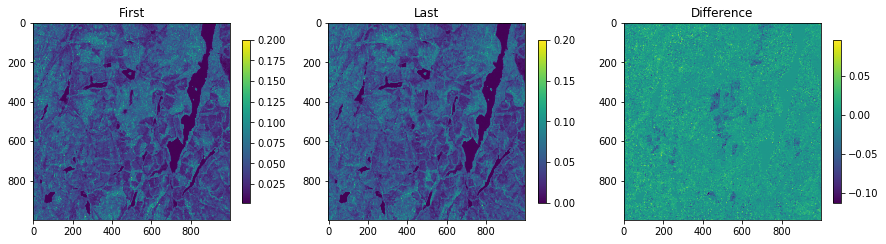

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

im = ax[0].imshow(hv_0, vmax=.2)
ax[0].set_title('First')
fig.colorbar(im, ax=ax[0], shrink=.3)


im = ax[1].imshow(hv_1_mod, vmax=.2)
ax[1].set_title('Last')
fig.colorbar(im, ax=ax[1], shrink=.3)

ax[2].set_title('Difference')
im = ax[2].imshow(diff)
fig.colorbar(im, ax=ax[2], shrink=.3)

# Thresholding

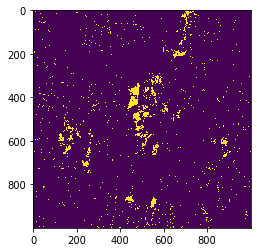

In [9]:
change_class = (diff < -.025).astype(int)
plt.imshow(change_class)

# Exercise 1

Experiment with a range of thresholds between `-0.05` and `-0.01`.

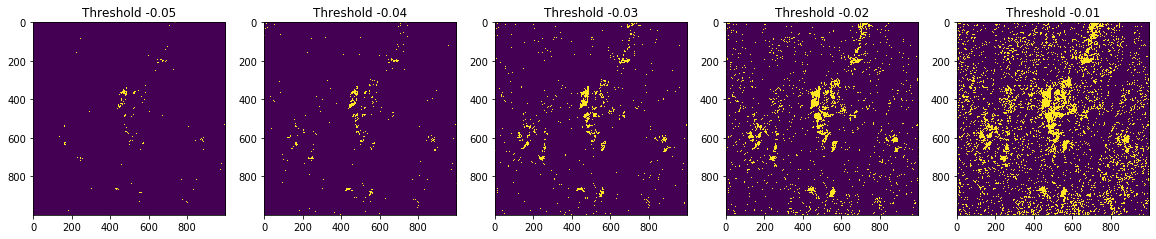

In [10]:
## Answer
thresholds = np.linspace(-.05, -.01,5)
N = len(thresholds)
fig, ax = plt.subplots(1, N, figsize=(20, 10))
for (ax, t) in zip(ax.ravel(), thresholds):
    ax.imshow((diff < t).astype(int))
    ax.set_title(f'Threshold {t:1.2f}')

# Morphological Filtering

We can actually segment a binary array into contiguous parts using [`label`](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.label.html#scipy.ndimage.measurements.label). Using these labels and measuring their size, we can actually filter according to size.

Below, we filter those areas that are less than 50 pixels.

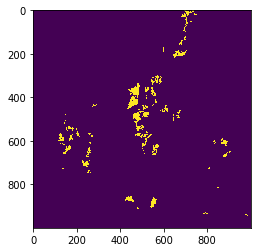

In [11]:
change_class_filtered = filter_binary_array_by_min_size(change_class, 50)

plt.imshow(change_class_filtered)

# Exercise 2

Determine the resolution and how large pixels should be so that only 1 ha areas of change ($10,000$ meter${}^3$) are registered. 

In [12]:
## Answer
10_000 / (12.5 * 12.5)

64.0

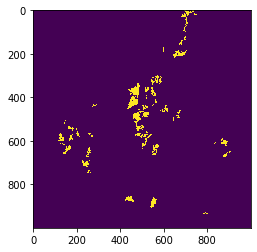

In [13]:
## Answer
change_class_filtered = filter_binary_array_by_min_size(change_class, 64)

plt.imshow(change_class_filtered)